Online EM algorithm for mixture with application
to internet traffic modeling

Z. Liua,∗, J. Almhanaa, V. Choulakiana, R. McGormanb

Modifications for n-dimension 

In [1]:
from math import exp, log


def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)


def poisson(x, l):
    poisson = 1
    for x_i, l_i in zip(x,l):
         poisson *= pow(l_i, x_i) * exp(-l_i) / factorial(x_i)
    return poisson

In [2]:
# we will start with a simple example
# create a generated poisson dataset for testing purposes
import numpy as np

def generate_data(g, l, size):
    data = np.array([])
    sizes = [int(gi * size) for gi in g]
 
    for gi, li in zip(sizes, l):
        data = np.append(data, np.random.poisson(li, gi))
    return data

total_points = 10000

data_x = generate_data([0.4, 0.6], [1, 5], total_points) 
data_y = generate_data([0.4, 0.6], [10, 15], total_points)
data = np.c_[data_x, data_y] 
np.random.shuffle(data)

In [3]:
class EMAlgorithm:
    def __init__(self, gammas, lambdas):
        # gammas and lambdas are the initialization
        self.gammas = np.array(gammas)
        self.lambdas = np.vstack(lambdas)
        assert len(gammas) == len(lambdas)
        assert self.lambdas.ndim > 1
        
        self.m = len(gammas)
        # the dimension of the Poisson distribution
        self.dim = len(self.lambdas[0])

        # list of the gammas_i
        # each element represent the value of gamma_i for an iteration
        self.gammas_over_time = [[] for _ in gammas]
        self.lambdas_over_time = [[] for _ in lambdas]
        self.likelihood = []

    def calculate_participation(self, data):
        """
        :param data: n array of the data to train
        :return: an (n, m) array of the participation of each data point to each poisson distribution
                m is the number of distributions
        """
        f = np.zeros(shape=(len(data), self.m))
        for i, x in enumerate(data):
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            f[i] = (self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas])) / total_x
        return f
    
    def calculate_likelihood(self, data):
        # naive implementation for likelihood calculation
        new_likelihood = 0
        for x in data:
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            new_likelihood = new_likelihood + log(total_x)
        return new_likelihood

    def run(self, data, iterations=100):
        n = len(data)
        
        for _ in range(iterations):
            f = self.calculate_participation(data)

            # update gammas and lambdas
            temp_sum = f.sum(axis=0)
            self.gammas = temp_sum / n

            temp = np.zeros(shape=(self.m, self.dim))
            for i, x in enumerate(data):
                temp = temp + np.vstack([x * f_i for f_i in f[i]])
            self.lambdas = np.vstack([temp[i] / temp_i for i,temp_i in enumerate(temp_sum)])

            # append last value of gammas and lambdas
            for i, gamma_i in enumerate(self.gammas):
                self.gammas_over_time[i].append(gamma_i)

            for i, lambda_i in enumerate(self.lambdas):
                self.lambdas_over_time[i].append(lambda_i)

            self.likelihood.append(self.calculate_likelihood(data))

    def get_gammas(self):
        return self.gammas_over_time

    def get_lambdas(self):
        return self.lambdas_over_time

    def get_likelihood(self):
        return np.array(self.likelihood)

In [45]:
import time

em = EMAlgorithm([0.5, 0.5], [[0.6, 8], [3, 12]])

start = time.time()
em.run(data, iterations=50)
end = time.time()

print('Time elapsed', end - start, 'sec')

Time elapsed 63.3384165763855 sec


### Plot results

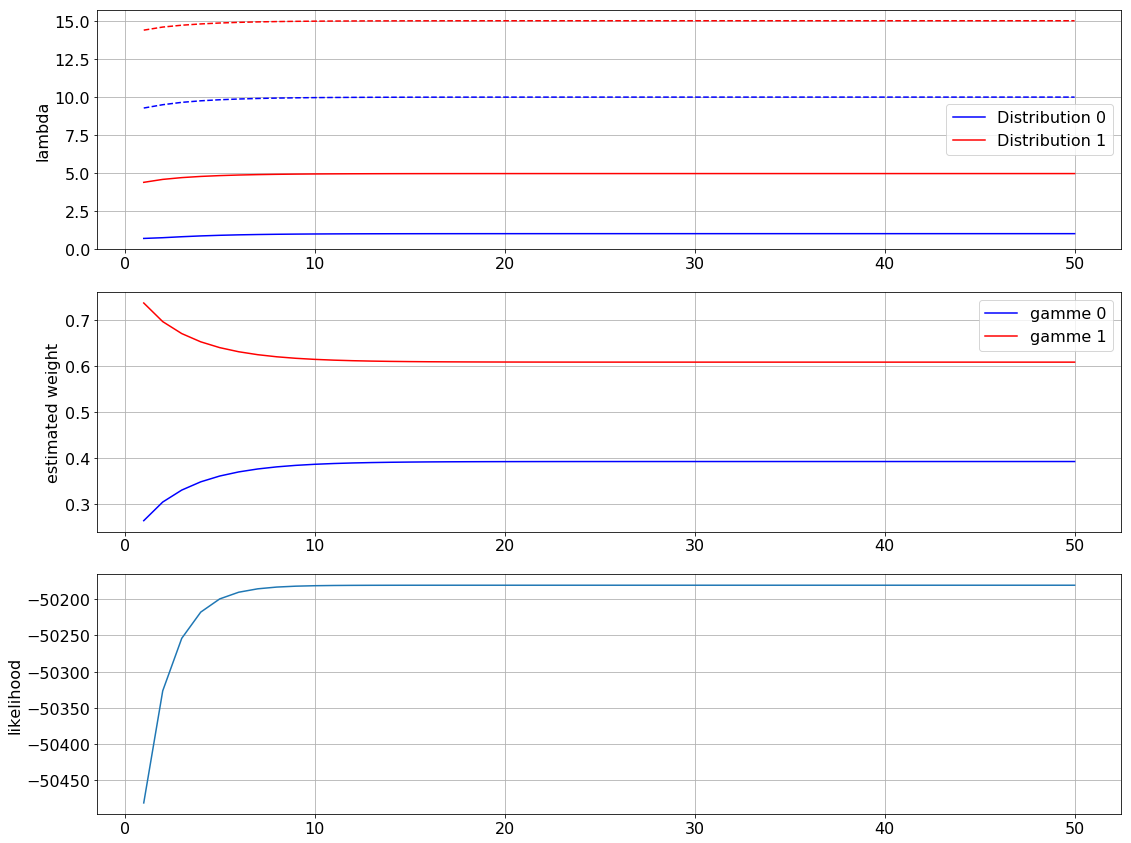

In [47]:
from matplotlib import pyplot as plt

colors = ['blue', 'red', 'green', 'yellow']
styles = ['-','--',':','-.']

from pylab import rcParams

def plot_results(em_algorithm):
    import matplotlib
    
    rcParams['figure.figsize'] = 16, 12
    rcParams['legend.loc'] = 'best'

    matplotlib.rcParams.update({'font.size': 16})

    x = range(1, len(em_algorithm.get_gammas()[1]) + 1)

    plt.title('Online EM 2.1 results')

    ax = plt.subplot(3, 1, 1)

    for i in range(len(em_algorithm.get_lambdas())):
        for j in range(em_algorithm.dim):
            if j == 0:
                a = plt.plot(x, np.array(em.get_lambdas()[i])[:,j], color=colors[i % len(colors)], 
                             linestyle=styles[j % len(styles)], label='Distribution ' + str(i))
            else:
                a = plt.plot(x, np.array(em.get_lambdas()[i])[:,j], color=colors[i % len(colors)], 
                             linestyle=styles[j % len(styles)])
    plt.ylabel('lambda')
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 2, sharex=ax)
    for i in range(len(em_algorithm.get_gammas())):
        plt.plot(x, em_algorithm.get_gammas()[i], color=colors[i % len(colors)], label='gamme ' + str(i))
    plt.ylabel('estimated weight')
    plt.legend()
    plt.grid()
    
    plt.subplot(3, 1, 3, sharex=ax)
    plt.plot(x, em_algorithm.get_likelihood())
    plt.ylabel('likelihood')
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    rcParams['figure.figsize'] = 16, 9

plot_results(em)

As eccepted in this ideal case we can simulate the data generating parameters with high accuracy

Next we display these centers compared to the points available

In [48]:
from collections import Counter

data_hashable = [tuple(x) for x in data]

values = np.vstack([list(x) for x in list(Counter(data_hashable).keys())])
counts = np.array(list(Counter(data_hashable).values()))

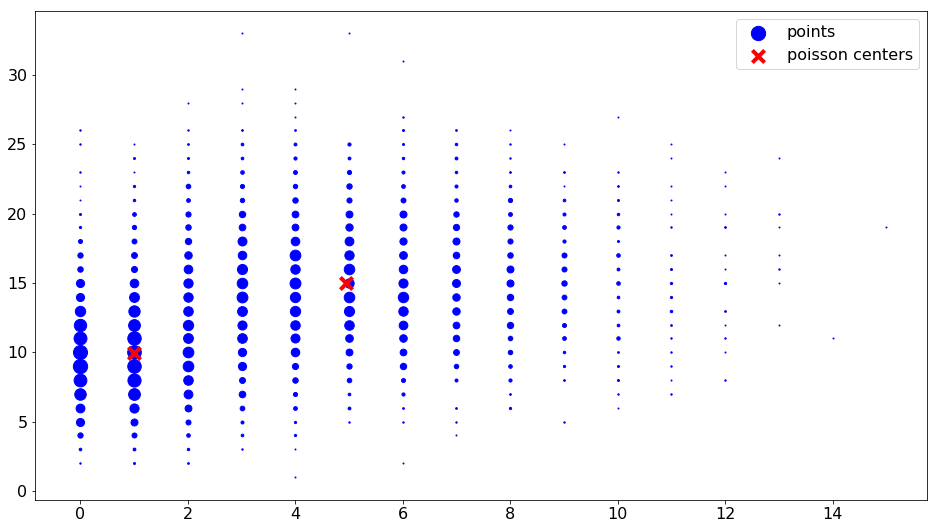

In [49]:
for i in range(len(values)):
    if counts[i] == max(counts):
        a = plt.scatter(values[i][0], values[i][1], s=counts[i]*10000/total_points, color='blue')
    else:
        plt.scatter(values[i][0], values[i][1], s=counts[i]*10000/total_points, color='blue')

for lambda_i in em.lambdas:
    b = plt.scatter(lambda_i[0], lambda_i[1], s=150, linewidth=4, color='red', marker='x')
    
plt.legend([a, b], ['points', 'poisson centers'])
plt.show()

Final result

In [73]:
from dsio.anomaly_detectors import AnomalyMixin


class OnlineEM(AnomalyMixin):
    def __init__(self, gammas, lambdas, segment_length):
        # gammas and lambdas are the initialization
        self.gammas = np.array(gammas)
        self.lambdas = np.vstack(lambdas)
        self.segment_length = segment_length
        
        assert len(gammas) == len(lambdas)
        assert self.lambdas.ndim > 1

        # number of poisson mixtures
        self.m = len(gammas)
        # the dimension of the Poisson distribution
        self.dim = len(self.lambdas[0])

        # list of the gammas_i
        # each element represent the value of gamma_i for an iteration
        self.gammas_over_time = [[] for _ in gammas]
        self.lambdas_over_time = [[] for _ in lambdas]
        self.likelihood = []

        # number of current iteration
        self.iteration_k = 0

    def calculate_participation(self, data):
        """
        :param data: n array of the data to train
        :return: an (n, m) array of the participation of each data point to each poisson distribution
                m is the number of distributions
        """
        f = np.zeros(shape=(len(data), self.m))
        for i, x in enumerate(data):
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            f[i] = (self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas])) / total_x
        return f

    def calculate_likelihood(self, data):
        # naive implementation for likelihood calculation
        new_likelihood = 0
        for x in data:
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            new_likelihood = new_likelihood + log(total_x)
        return new_likelihood

    def update(self, data):
        """
        :param data: the batch data 
        updates gammas, lambdas and likelihood
        """

        self.iteration_k += 1
        n = len(data)
        if n <= 0:
            return
        assert len(data[0]) == len(self.lambdas[0])
        
        f = self.calculate_participation(data)

        # update gammas and lambdas
        temp_sum = f.sum(axis=0)

        update_factor = 1 / (pow(self.iteration_k, 0.6))
        self.gammas = (1 - update_factor) * self.gammas + update_factor * (temp_sum / n)

        temp = np.zeros(shape=(self.m, self.dim))
        for i, x in enumerate(data):
            temp = temp + np.vstack([x * f_i for f_i in f[i]])
        new_lambdas = np.vstack([temp[i] / temp_i for i,temp_i in enumerate(temp_sum)])
        
        self.lambdas = (1 - update_factor) * self.lambdas + update_factor * new_lambdas
        
        # append last value of gammas and lambdas
        for i, gamma_i in enumerate(self.gammas):
            self.gammas_over_time[i].append(gamma_i)

        for i, lambda_i in enumerate(self.lambdas):
            self.lambdas_over_time[i].append(lambda_i)

        self.likelihood.append(self.calculate_likelihood(data))

    def get_new_batch(self, data, pos):
        n = len(data)

        assert self.segment_length <= n

        if self.segment_length + pos <= n:
            return data[pos: pos + self.segment_length], pos + self.segment_length

        return data[pos:], n

    def train(self, data):
        """
        Runs a simulated batch processing of the whole data 
        :param data: the whole data set to train from 
        :param batch_number: the number of iterations to perform on data with barch_size self.batch_size
        """

        # the starting position of the current batch in the data
        pos = 0
        while pos < len(data):
            batch, pos = self.get_new_batch(data, pos)

            self.update(batch)

    def fit(self, x):
        """
        For fitting the initial values update function is called 
        Depending on the use of the update factor initial values may have an impact or not
        :param x: data
        """
        self.update(x)

    # TODO
    def score_anomaly(self, x):
        pass

    # TODO
    def flag_anomaly(self, x):
        pass

    def get_gammas(self):
        return self.gammas_over_time

    def get_lambdas(self):
        return self.lambdas_over_time

    # TODO average or update based on factor the final likelihood?
    def get_likelihood(self):
        return self.likelihood

    def get_bic(self, data):
        """
        :return a tuple of the bic avg_log_likelihoods and the log likelihood of the whole data
        """
        """
        REMOVE?
        # get same batches as in train procedure
        pos = 0
        total_likelihood = 0
        while pos < len(data):
            batch, pos = self.get_new_batch(data, pos)
            total_likelihood += self.calculate_likelihood(batch)

        return ((-2) / self.iteration_k) * total_likelihood + log(len(data)) * (2 * self.m - 1), total_likelihood
        """
        return ((-2) / self.iteration_k) * self.calculate_likelihood(data) + log(len(data)) * (2 * self.m - 1), self.calculate_likelihood(data)
        

In [74]:
onlineEM = OnlineEM([0.5, 0.5], [[0.6, 8], [3, 12]], 1000)

start = time.time()
onlineEM.train(data)
end = time.time()

print('Time elapsed', end - start, 'sec')

Time elapsed 2.488240957260132 sec


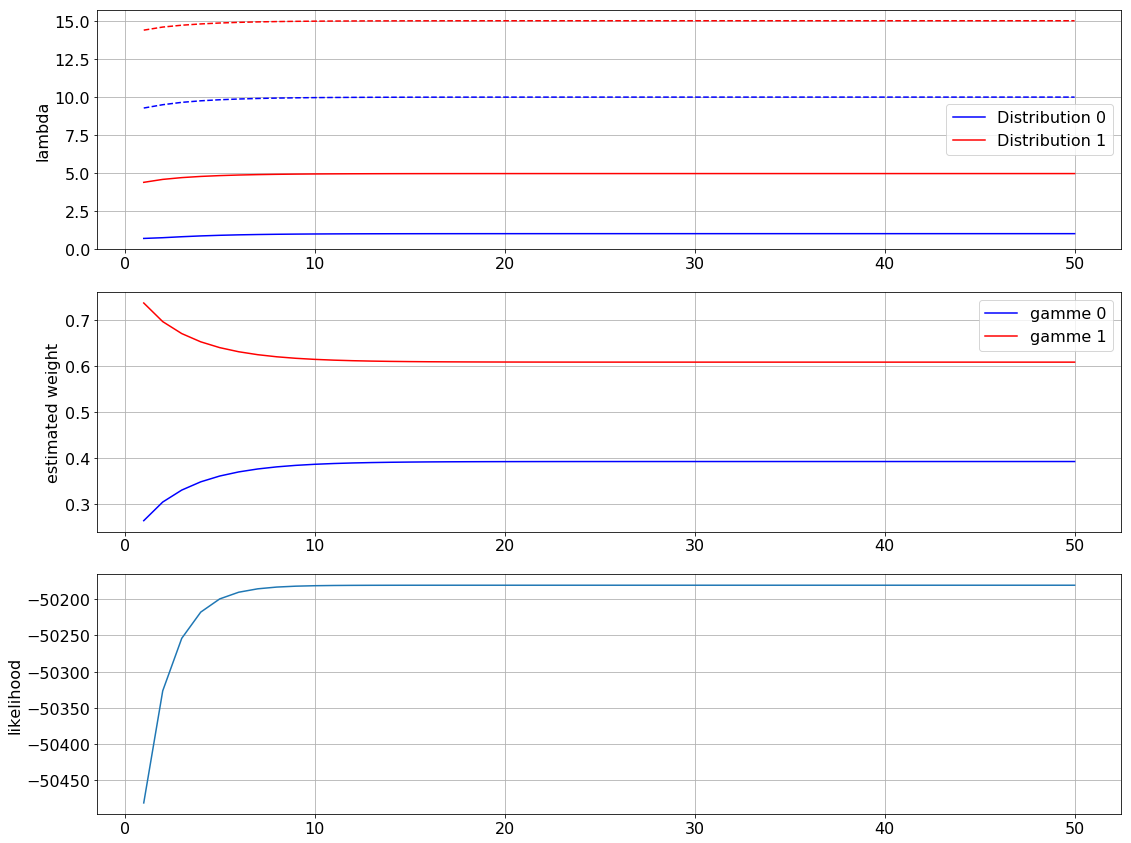

In [75]:
plot_results(em)

We can also try to simulate this distribution with a different number of Poisson distribution

In [89]:
number_of_mixtures = list(range(1,11))
avg_log_likelihoods = []
bics = []


for m in number_of_mixtures:
    onlineEM = OnlineEM([1/m]*m, np.array(range(1,m*2 + 1)).reshape((m,2)), 500)
    onlineEM.train(data)
    bic, avg_log_likelihood = onlineEM.get_bic(data)
    bics.append(bic)
    avg_log_likelihoods.append(avg_log_likelihood)

Average log likelihood should probably always increase as the number of mixtures used increases?

Nt exactly the case in this case.

avg_log_likelihoods = [-54282.7046790716, -50323.425097007654, -50200.729321023464, -50199.99655507412, -50206.81816726789, -50212.543734175924, -50214.79865193571, -50215.55218273542, -50215.72005543569, -50215.725261261134]

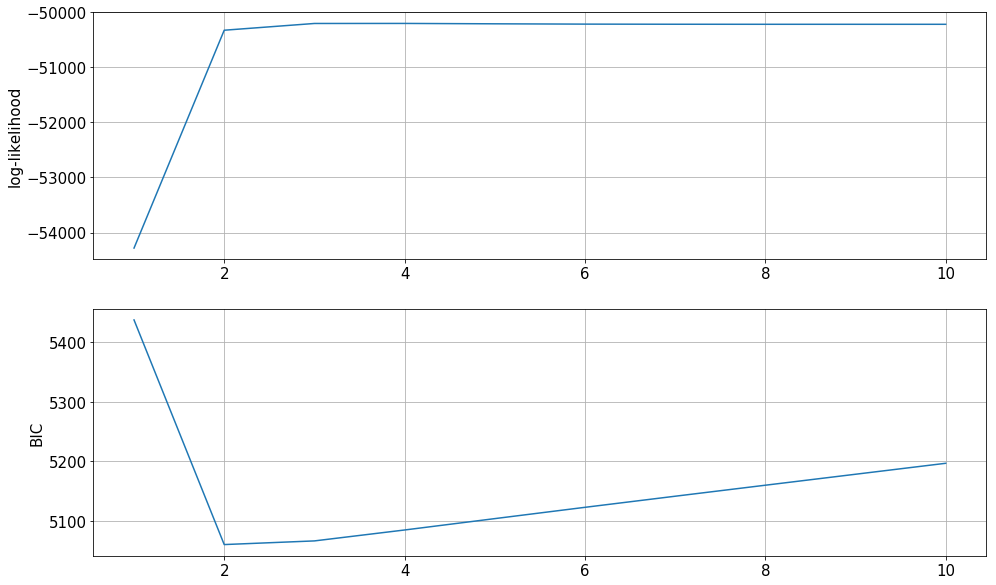

In [90]:
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
%matplotlib inline 

rcParams['figure.figsize'] = 16, 10

matplotlib.rcParams.update({'font.size': 15})

plt.title('Results')

plt.subplot(2, 1, 1)
plt.plot(number_of_mixtures, avg_log_likelihoods)
plt.ylabel('log-likelihood')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(number_of_mixtures, bics)
plt.ylabel('BIC')
plt.grid()

plt.show()

As we can by the BIC coefficient, 2 is the best number of mixtures to be used.